In [2]:
import cv2
import numpy as np
from scipy import ndimage
from skimage import measure, color, io

In [3]:
# rotation, flip
def flip(img, flag):
    return cv2.flip(flag) # 0 -> vertical; 1 -> horizontal

def rotate(img, theta):
    angle = int(random.uniform(-theta, theta))
    h,w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

# brightness
def brightness(img, low=0.2, high=2):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

# sharpen
def sharpen(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    image_sharp = cv2.filter2D(src=im, ddepth=-1, kernel=kernel)
    return image_sharp

def blur(img, sig_x=0, sig_y=0):
    blur = cv2.GaussianBlur(im,(5,5),sig_x, sig_y)
    return blur

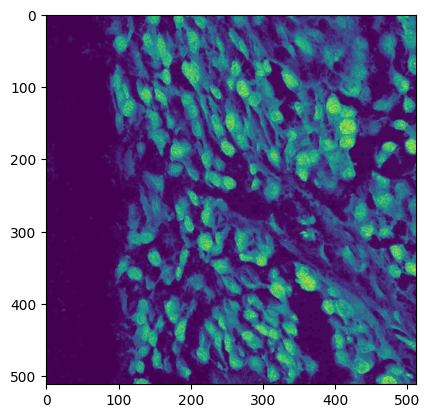

In [20]:
# morphology operation
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu # seperate background & foreground
from skimage.morphology import closing, opening, disk
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

file_name = '../tile_data/TCGA-DK-A2I6-01_0000.png'
im = cv2.imread(file_name)

cells = im[:, :, 0]

plt.imshow(im)

hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

plt.imshow(hsv[:, :, 1])

cells = hsv[:, :, 1]

ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# cv2.imshow('img', image_sharp)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# hed = rgb2hed(im)
# #plt.imshow(hed[:, :, 0])

# t = threshold_otsu(hed[:, :, 0])
# print(t)
# mask = hed[:, :, 0]>t
# mask = closing(im) # opening: remove small objects & thin lines; closing: 
# plt.imshow(mask)

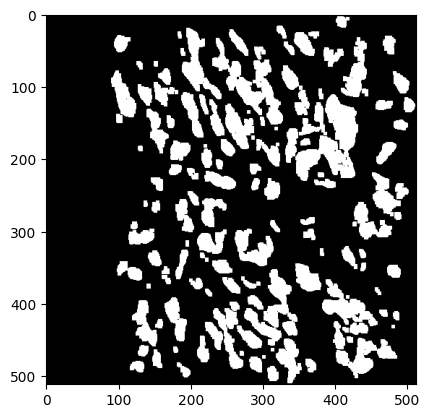

In [21]:
from skimage.segmentation import clear_border
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
opening = clear_border(opening)
plt.imshow(opening, cmap='gray')

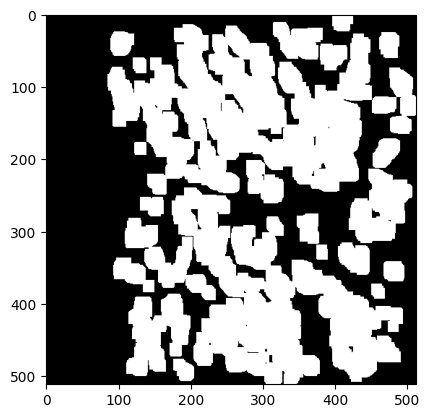

In [27]:
# Watershed
sure_bg = cv2.dilate(opening, kernel, iterations=5)
plt.imshow(sure_bg, cmap='gray')

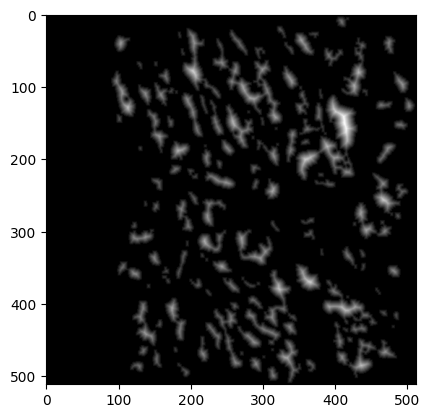

In [41]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
plt.imshow(dist_transform, cmap='gray')

In [42]:
print(dist_transform.max())

15.787567


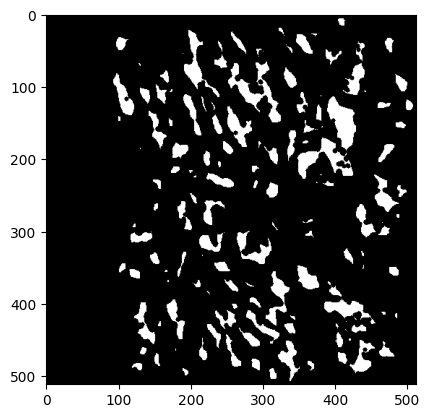

In [43]:
ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)
plt.imshow(sure_fg, cmap='gray')

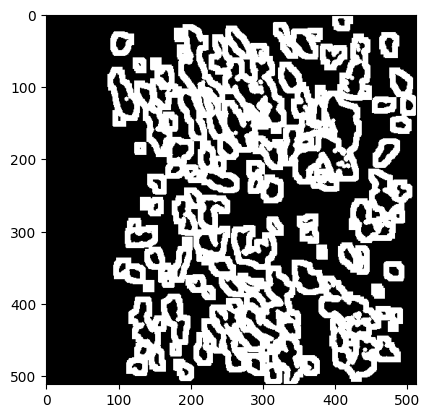

In [44]:
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')

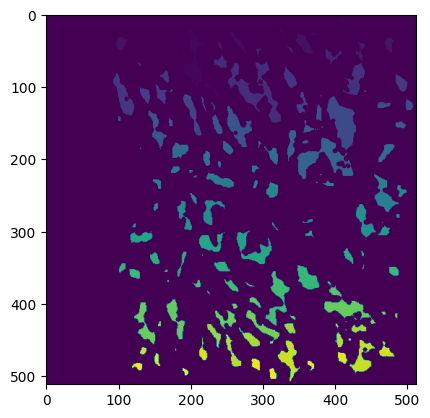

In [45]:
ret3, markers = cv2.connectedComponents(sure_fg)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# marker = cv2.morphologyEx(marker, cv2.MORPH_OPEN, kernel)
plt.imshow(markers)

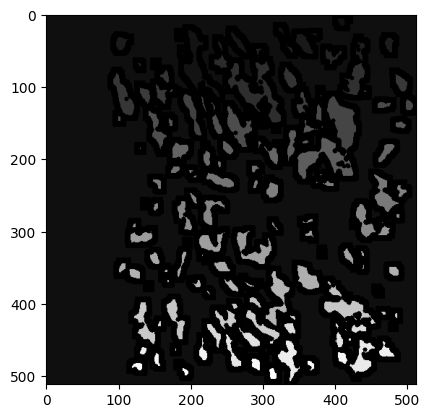

In [46]:
markers += 10
markers[unknown==255] = 0 # unknown should label as 0
plt.imshow(markers, cmap='gray') # background has value of 10, unknown is 0, 

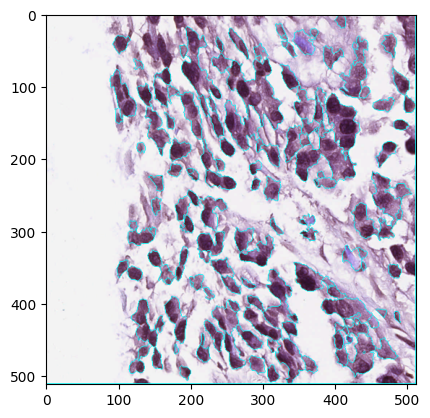

In [49]:
markers = cv2.watershed(im, markers)
im[markers==-1] = [0, 255, 255] # yellow

im2 = color.label2rgb(markers, bg_label=0)
plt.imshow(im2)
plt.imshow(im)

In [48]:
cv2.imshow("Overlay", im)
cv2.imshow('colored', im2)
cv2.waitKey(1)

-1